In [4]:
import sys
sys.path.append('..')
%pip install pandas numpy matplotlib seaborn pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data.load import load_unsw_nb15_parquet
from pathlib import Path

df = load_unsw_nb15_parquet('../data/raw')
print("\n Parquet данные успешно загружены")

# 2. Детальный анализ структуры
print(f"Общий размер: {df.shape[0]:,} строк, {df.shape[1]} столбцов")

# 3. Анализ памяти (parquet обычно эффективнее)
print(f"\nИспользование памяти: {round(df.memory_usage(deep=True).sum() / 1024**2, 2)} MB")

# 4. Просмотр уникальных значений в ключевых столбцах
print("\n Ключевые столбцы")
key_columns = ['label', 'attack_cat', 'proto', 'service', 'state']
for col in key_columns:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Уникальных значений: {df[col].nunique()}")
        print(f"  Распределение:")
        print(df[col].value_counts().head())

Note: you may need to restart the kernel to use updated packages.
Нашёл! 2 файлов:
 - UNSW_NB15_testing-set.parquet
 - UNSW_NB15_training-set.parquet
Загружаем UNSW_NB15_testing-set.parquet...
  Shape: (82332, 36)
  Columns: 36
Загружаем UNSW_NB15_training-set.parquet...
  Shape: (175341, 36)
  Columns: 36
Датасет установлен успешно: 257673 строки, 36 столбцы

 Parquet данные успешно загружены
Общий размер: 257,673 строк, 36 столбцов

Использование памяти: 49.93 MB

 Ключевые столбцы

label:
  Уникальных значений: 2
  Распределение:
label
1    164673
0     93000
Name: count, dtype: int64

attack_cat:
  Уникальных значений: 10
  Распределение:
attack_cat
Normal      93000
Generic     58871
Exploits    44525
Fuzzers     24246
DoS         16353
Name: count, dtype: int64

proto:
  Уникальных значений: 133
  Распределение:
proto
tcp     123041
udp      92701
unas     15599
arp       3846
ospf      3271
Name: count, dtype: int64

service:
  Уникальных значений: 13
  Распределение:
service
- 

In [9]:
# Проверяем наличие тренировочного набора
if 'UNSW_NB15_training-set' in str(list(Path("../data/raw").glob("*.parquet"))):
    print("Найден тренировочный набор")
else:
    print("Только тестовый набор. И это не мои проблемы, ок? Ищи, скачивай, мне вообще разницы нет с чем работать.")

# Анализ распределения в тестовом наборе
print("\nРаспределение в тестовом наборе:")
print("Метки (label):")
print(df['label'].value_counts(normalize=True) * 100)

if 'attack_cat' in df.columns:
    print("\nТипы атак (attack_cat):")
    print(df['attack_cat'].value_counts(normalize=True) * 100)

Найден тренировочный набор

Распределение в тестовом наборе:
Метки (label):
label
1    63.907744
0    36.092256
Name: proportion, dtype: float64

Типы атак (attack_cat):
attack_cat
Normal            36.092256
Generic           22.847175
Exploits          17.279653
Fuzzers            9.409601
DoS                6.346416
Reconnaissance     5.428198
Analysis           1.038914
Backdoor           0.903859
Shellcode          0.586402
Worms              0.067527
Name: proportion, dtype: float64


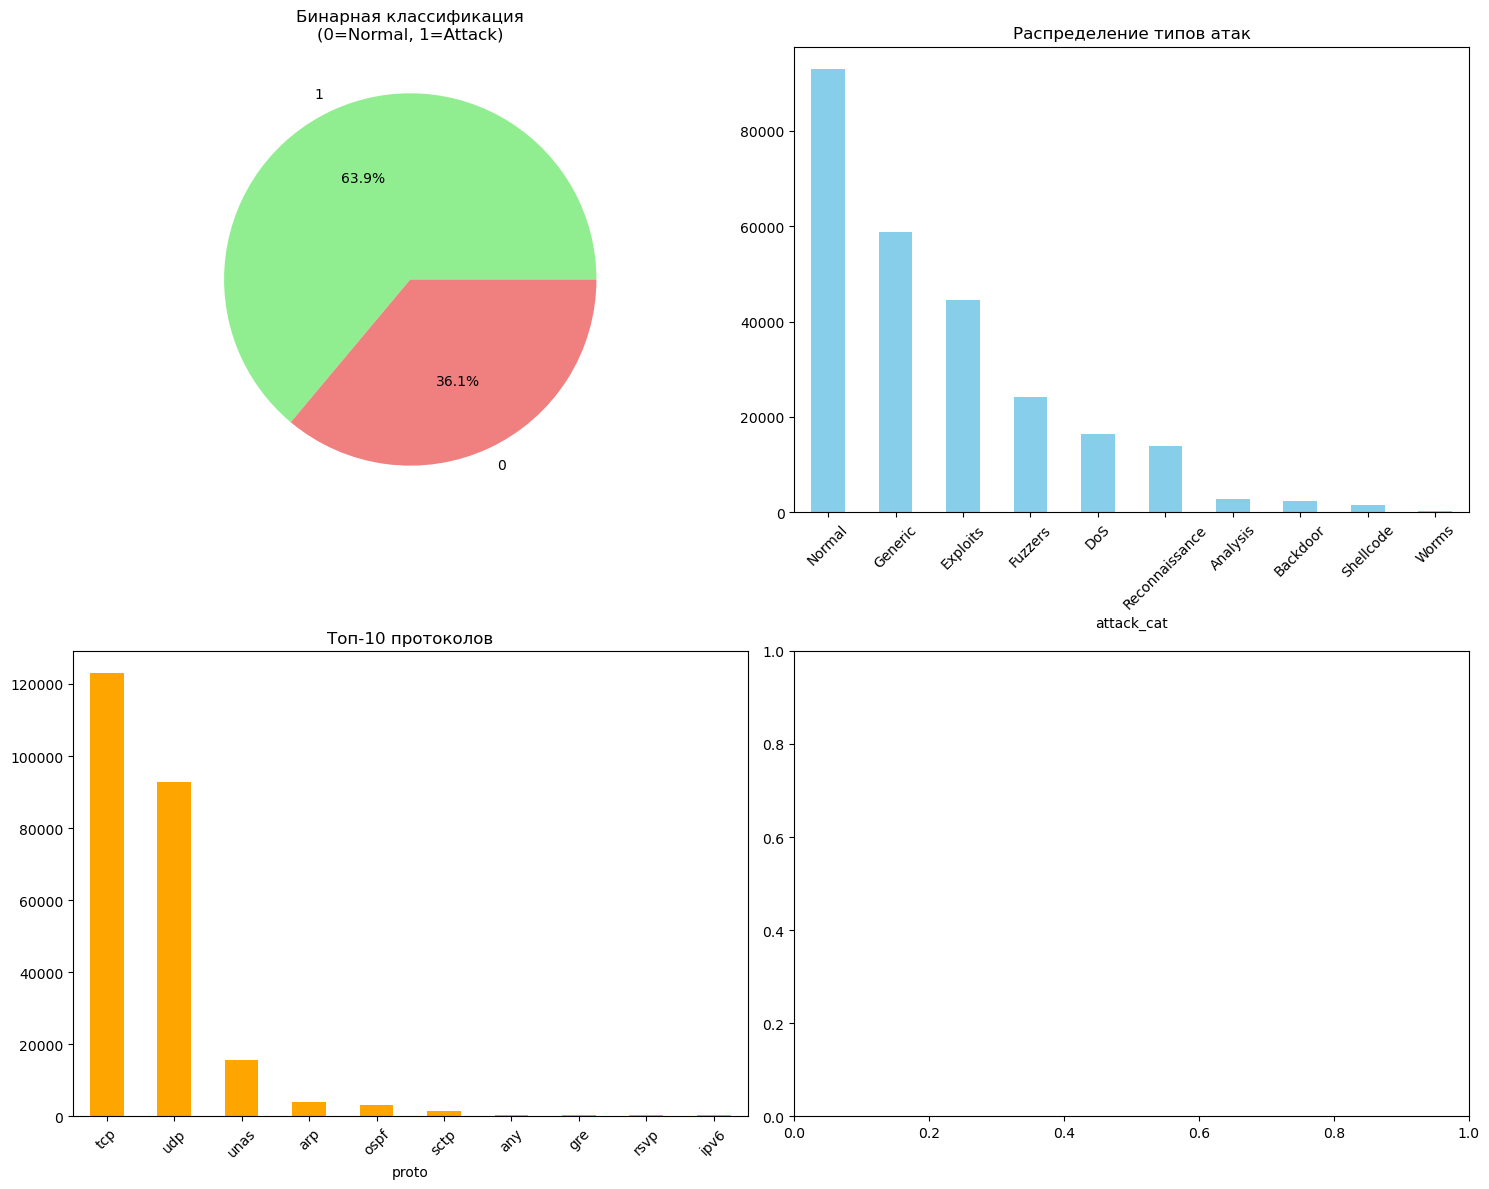

In [10]:
def plot_parquet_analysis(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Распределение бинарных меток
    df['label'].value_counts().plot(
        kind='pie', ax=axes[0,0], autopct='%1.1f%%', 
        colors=['lightgreen', 'lightcoral']
    )
    axes[0,0].set_title('Бинарная классификация\n(0=Normal, 1=Attack)')
    axes[0,0].set_ylabel('')
    
    # 2. Распределение типов атак (если есть)
    if 'attack_cat' in df.columns:
        attack_counts = df['attack_cat'].value_counts()
        attack_counts.plot(kind='bar', ax=axes[0,1], color='skyblue')
        axes[0,1].set_title('Распределение типов атак')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Топ протоколов
    if 'proto' in df.columns:
        df['proto'].value_counts().head(10).plot(
            kind='bar', ax=axes[1,0], color='orange'
        )
        axes[1,0].set_title('Топ-10 протоколов')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Распределение длительности соединений
    if 'duration' in df.columns:
        # Логарифмическая шкала для лучшего отображения
        df['duration_log'] = np.log1p(df['duration'])
        df['duration_log'].hist(bins=50, ax=axes[1,1], alpha=0.7)
        axes[1,1].set_title('Распределение длительности\n(логарифмическая шкала)')
        axes[1,1].set_xlabel('log(duration + 1)')
    
    plt.tight_layout()
    plt.show()

# Запускаем визуализацию
plot_parquet_analysis(df)



	Проверка целостности данных

Типы данных:
float32     11
int16        9
int8         7
int32        3
int64        2
object       2
category     1
category     1
Name: count, dtype: int64

Проверка аномальных значений:

Анализ корреляций


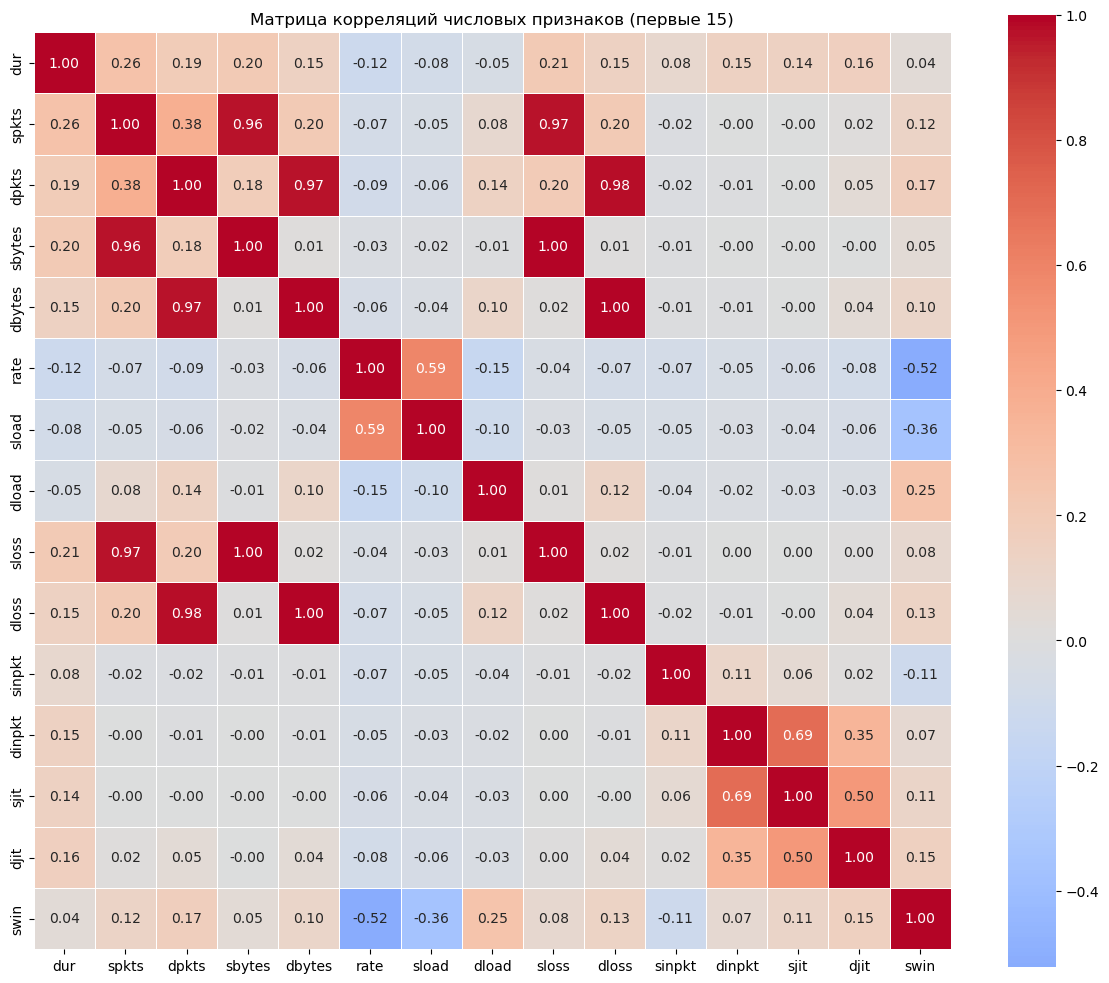


Корреляции с целевой переменной (label):
label               1.000000
ct_dst_sport_ltm    0.371672
swin                0.364877
dload               0.352169
dwin                0.339166
rate                0.335883
ct_src_dport_ltm    0.318518
dmean               0.295173
stcpb               0.266585
dtcpb               0.263543
dtype: float64


In [11]:
print("\n\tПроверка целостности данных")

print("\nТипы данных:")
print(df.dtypes.value_counts())

print("\nПроверка аномальных значений:")
for col in ['srcip', 'dstip', 'sport', 'dsport']:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} уникальных значений")

print("\nАнализ корреляций")
numerical_cols = df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 1:
    # Берем только первые 15 числовых признаков для читаемости
    corr_matrix = df[numerical_cols[:15]].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Матрица корреляций числовых признаков (первые 15)')
    plt.tight_layout()
    plt.show()
    
    # Анализ корреляций с целевой переменной
    if 'label' in df.columns:
        target_correlations = df[numerical_cols].corrwith(df['label']).abs().sort_values(ascending=False)
        print("\nКорреляции с целевой переменной (label):")
        print(target_correlations.head(10))

Данные сохранены в: data\processed\unsw_nb15_processed.parquet


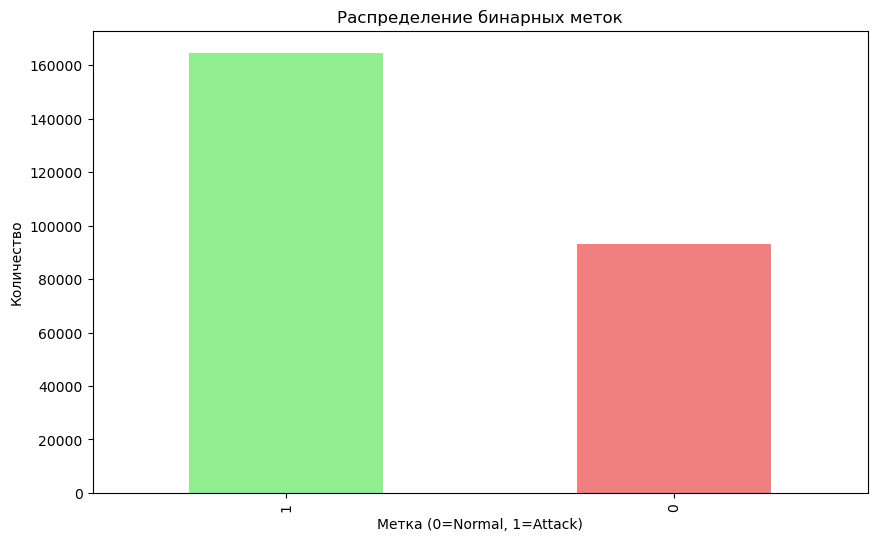

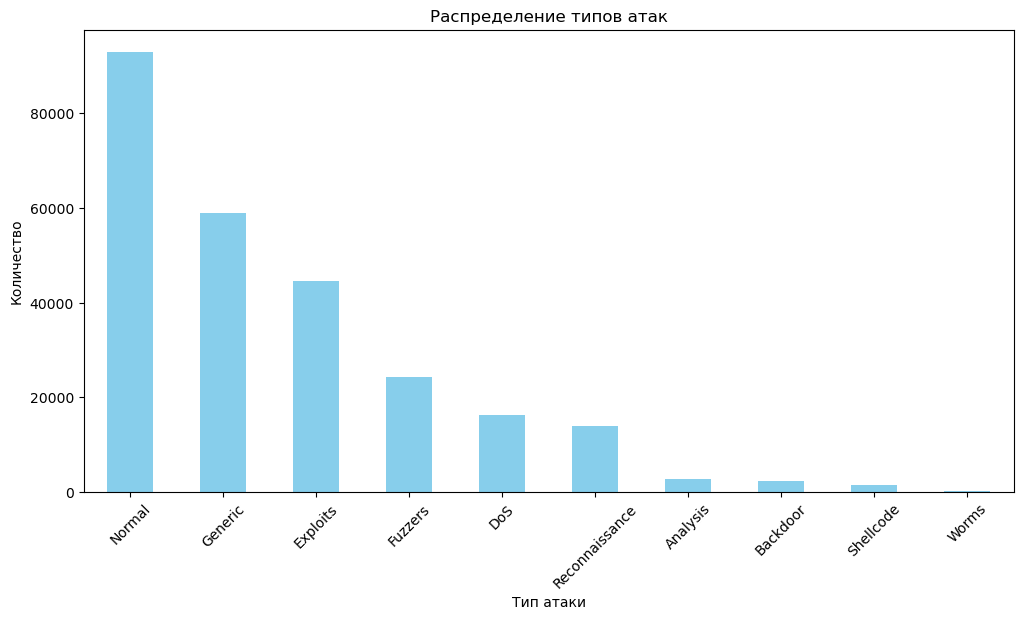


АНАЛИЗ PARQUET ДАННЫХ UNSW-NB15
Время анализа: 2025-11-17 12:37:51.003204
Файлы: []
Общий размер: 257,673 строк, 36 столбцов
Память: 49.93 MB

РАСПРЕДЕЛЕНИЕ МЕТОК:
Нормальный трафик (0): 93,000 (36.1%)
Атаки (1): 164,673 (63.9%)

ТИПЫ ДАННЫХ:
float32     11
int16        9
int8         7
int32        3
int64        2
object       2
category     1
category     1
Name: count, dtype: int64

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
Всего пропусков: 0
Столбцы с пропусками: {}

РЕКОМЕНДАЦИИ ДЛЯ ПРЕДОБРАБОТКИ:
1. Обработка категориальных признаков: ['proto', 'state']
2. Нормализация числовых признаков: 32 признаков
3. Дисбаланс приемлемый

Сводка анализа сохранена в: reports\figures\data_analysis_summary.txt


In [12]:
# Создаем папку для результатов
output_path = Path("data/processed")
output_path.mkdir(parents=True, exist_ok=True)

reports_path = Path("reports/figures")
reports_path.mkdir(parents=True, exist_ok=True)

# Сохраняем обработанные данные
df.to_parquet(output_path / "unsw_nb15_processed.parquet", index=False)
print(f"Данные сохранены в: {output_path / 'unsw_nb15_processed.parquet'}")

# Сохраняем ключевые графики
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Распределение бинарных меток')
plt.xlabel('Метка (0=Normal, 1=Attack)')
plt.ylabel('Количество')
plt.savefig(reports_path / 'label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

if 'attack_cat' in df.columns:
    plt.figure(figsize=(12, 6))
    df['attack_cat'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Распределение типов атак')
    plt.xlabel('Тип атаки')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.savefig(reports_path / 'attack_types_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
# Генерируем текстовую сводку
summary = f"""
АНАЛИЗ PARQUET ДАННЫХ UNSW-NB15
{'='*50}
Время анализа: {pd.Timestamp.now()}
Файлы: {[f.name for f in Path('data/raw').glob('*.parquet')]}
Общий размер: {df.shape[0]:,} строк, {df.shape[1]} столбцов
Память: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB

РАСПРЕДЕЛЕНИЕ МЕТОК:
Нормальный трафик (0): {(df['label'] == 0).sum():,} ({(df['label'] == 0).mean()*100:.1f}%)
Атаки (1): {(df['label'] == 1).sum():,} ({(df['label'] == 1).mean()*100:.1f}%)

ТИПЫ ДАННЫХ:
{df.dtypes.value_counts()}

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
Всего пропусков: {df.isnull().sum().sum()}
Столбцы с пропусками: {df.isnull().sum()[df.isnull().sum() > 0].to_dict()}

РЕКОМЕНДАЦИИ ДЛЯ ПРЕДОБРАБОТКИ:
1. Обработка категориальных признаков: {list(df.select_dtypes(include=['object']).columns)}
2. Нормализация числовых признаков: {len(df.select_dtypes(include=[np.number]).columns)} признаков
3. {"Балансировка классов рекомендуется" if abs((df['label'] == 0).mean() - 0.5) > 0.3 else "Дисбаланс приемлемый"}
"""

print(summary)

# Сохраняем сводку
with open(reports_path / "data_analysis_summary.txt", "w", encoding='utf-8') as f:
    f.write(summary)

print(f"Сводка анализа сохранена в: {reports_path / 'data_analysis_summary.txt'}")